# CrossValidation
[公式ドキュメント](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

下ごしらえ

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact
import seaborn as sns

In [25]:
from sklearn.datasets import load_iris
iris=load_iris()
data=iris.data
target=iris.target
from sklearn.utils import shuffle

In [4]:
from sklearn.svm import SVC
clf=SVC(probability=True)

# 今回のお題

In [5]:
from sklearn import cross_validation as cv

- モデルのインスタンス、記述子、ラベル、分割数、ジョブ数(-1でコア数分並列)を指定してあげると一行でクロスバリデーションできる


In [6]:
score=cv.cross_val_score(clf,data,target,cv=5,n_jobs=-1)

- scoreのデフォルトは正答率（accurary）

- 他にもあるけどマルチクラス分類では使えないのが多い。

- [参照](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In [7]:
print("all: ",score)
print("Accuracy: {0:04.4f} (+/- {1:04.4f})".format(score.mean(),score.std()))

all:  [ 0.96666667  1.          0.96666667  0.96666667  1.        ]
Accuracy: 0.9800 (+/- 0.0163)


単純に入力順にn分割している様子  
入力をシャッフルすればOK

In [43]:
data_shuffle,target_shuffle=shuffle(data,target)
cv.cross_val_score(clf,data_shuffle,target_shuffle,n_jobs=-1,cv=5)

array([ 0.9       ,  1.        ,  0.96666667,  0.96666667,  1.        ])

### SVMのコストパラメータを探索する場合

- まずざっくりとlogscaleでコストを振ってみる

In [44]:
C_params=np.logspace(-2, 2, 9)
scores=list()
for C in C_params:
    clf.C=C
    tmp_score=cv.cross_val_score(clf,data_shuffle,target_shuffle,cv=5,n_jobs=-1)
    scores.append(np.mean(tmp_score))

コスト探索の可視化

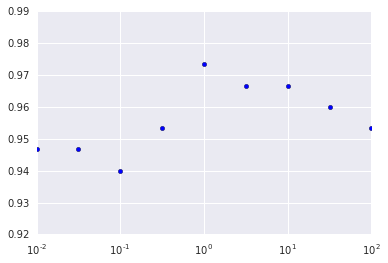

In [45]:
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlim(0.01,100)
ax.scatter(C_params,scores)

- 桁を抑えたところで0.01-10まで探索してみる

In [50]:
C_params2=np.linspace(0.001,10,21)
scores2=list()
for C in C_params2:
    clf.C=C
    tmp_score=cv.cross_val_score(clf,data_shuffle,target_shuffle,cv=5,n_jobs=-1)
    scores2.append(np.mean(tmp_score))

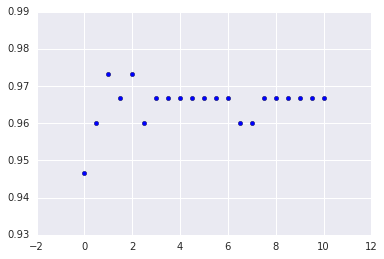

In [51]:
plt.scatter(C_params2,scores2)

- 細かく探索して終了

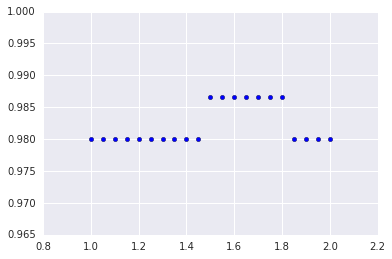

In [52]:
C_params3=np.linspace(1,2,21)
scores3=list()
for C in C_params3:
    clf.C=C
    tmp_score=cv.cross_val_score(clf,data,target,cv=5,n_jobs=-1)
    scores3.append(np.mean(tmp_score))
plt.scatter(C_params3,scores3)

- ランダムシャッフリングして確認してみる。

In [56]:
clf.C=1.6
data_shuffle,target_shuffle=shuffle(data,target)
score=cv.cross_val_score(clf,data_shuffle,target_shuffle,cv=5)
print("Accuracy: {0:04.4f} (+/- {1:04.4f})".format(score.mean(),score.std()))

Accuracy: 0.9600 (+/- 0.0249)


あまりチューニングできてない...

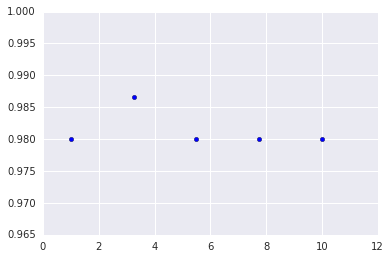

In [16]:
@interact(min_C=(1,10,1),max_C=(1,10,1),step=(5,20,1))
def cost_search(min_C=1,max_C=10,step=5):
    params=np.linspace(min_C,max_C,step)
    rslt=list()
    for C in params:
        clf.C=C
        rslt.append(np.mean(cv.cross_val_score(clf,data,target,cv=5,n_jobs=-1)))
    plt.scatter(params,rslt)

# おまけ
> cross_val_scoreを使わず実装するなら

In [17]:
skf=cv.StratifiedKFold(target,n_folds=5,shuffle=True) # generaterを作成する
for i in skf:pass
i # 一個一個のgeneraterにはindexのリストが含まれている

(array([  0,   1,   2,   5,   8,   9,  10,  11,  12,  13,  14,  15,  16,
         17,  18,  19,  23,  24,  25,  27,  28,  29,  30,  31,  32,  33,
         34,  35,  36,  37,  38,  40,  41,  42,  43,  44,  45,  46,  48,
         49,  50,  53,  54,  55,  56,  57,  59,  60,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  73,  74,  75,  76,  77,  78,  79,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  91,  92,  93,  94,  95,
         96,  97, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128,
        129, 130, 131, 132, 134, 135, 136, 137, 139, 142, 143, 145, 146,
        147, 148, 149]),
 array([  3,   4,   6,   7,  20,  21,  22,  26,  39,  47,  51,  52,  58,
         61,  62,  72,  89,  90,  98,  99, 108, 112, 113, 114, 125, 133,
        138, 140, 141, 144]))

In [18]:
score=list()
for train_index,test_index in skf:
    data_train=data[train_index]
    data_test=data[test_index]
    target_train=target[train_index]
    target_test=target[test_index]
    clf.fit(data_train,target_train)
    rslt=clf.predict(data_test)
    tmp_score=0
    for i,j in enumerate(rslt):
        if j==target_test[i]:tmp_score+=1
    score.append(tmp_score/len(test_index))
score=np.array(score)
print("all: ",score)
print("Accuracy: {0:04.4f} (+/- {1:04.4f})".format(score.mean(),score.std()))

all:  [ 1.          0.9         0.96666667  1.          0.96666667]
Accuracy: 0.9667 (+/- 0.0365)


# トレーニング/検証用データの分割

> cv.train_test_split

- マニュアルで二分割したい時

In [19]:
data_train,data_test,target_train,target_test=cv.train_test_split(
                                                data,target,train_size=0.95)

In [20]:
print(len(data_train))
print(len(data_test))
print(len(target_train))
print(len(target_test))

142
8
142
8


- train_sizeで0~1の範囲で分割する
- 最初に出てくるものがtrain用データ
- random_stateでseed固定も可能
- 実は分割したい配列は１つや２つだけでなく、いくつでも渡せる

In [21]:
clf.fit(data_train,target_train)
target_pred=clf.predict(data_test)

In [22]:
pd.DataFrame(np.c_[target_pred,target_test],columns=["prediction","fact"]).T

,0,1,2,3,4,5,6,7
prediction,0,2,1,2,0,1,1,1
fact,0,2,1,2,0,1,1,1


shuffleと同様に、random_stateを指定せずに分割すると、１行で実行しないとばらばらなseedでランダム分割されるので注意

In [23]:
data_train_NG,data_test_NG=cv.train_test_split(data,train_size=0.95)
target_train_NG,target_test_NG=cv.train_test_split(target,train_size=0.95)#上とseedが違う可能性あり!!

In [24]:
clf.fit(data_train_NG,target_train_NG)
target_pred_NG=clf.predict(data_test_NG)
pd.DataFrame(np.c_[target_pred_NG,target_test_NG],columns=["prediction","fact"]).T

,0,1,2,3,4,5,6,7
prediction,0,1,0,2,2,0,0,2
fact,1,1,0,2,0,0,2,2


ここまでやってなんですが、CVを単独で使うケースは少ないです。
次で紹介するGridSearchはGridSearchCVでまとめてやるほうが多い気がします。

# 終わり
@y__sama